eval / error,█▄▃▂▂▁▁▁▁▁▁▁
eval / loss,█▃▂▂▂▁▁▁▁▁▁▁
harmonic / distance_median,██▆▆▂▂▂▁▁▂▁▁▂▁▂▁▁▁▂▂▂▁▁▁▂▂▁▂▁▂▂▂▁▁▂▂▂▂▂▂
harmonic / effective_samples,███▆▃▁▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
harmonic / prob_median,██▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train / error,█▂▁▁▁▁▁▁▁▁▁▁
train / gradient_norm,▆█▇▇▇▆▆▇▃▇▂▃▂▅▁▄▃▁▅▁▄▃▂▁▃▄▄▃▇▃▄▆▅▄▄▁▂▃▁▄
train / loss,█▇█▆▆▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁
eval / error,0.0088
eval / loss,0.02764
harmonic / distance_median,3.84023



Epoch 1/20


Train loss: 0.6664, Train error: 43.548%


Eval loss: 0.6873, Eval error: 10.080%

Epoch 2/20


Train loss: 0.1739, Train error: 6.582%


Eval loss: 0.1307, Eval error: 3.350%

Epoch 3/20


Train loss: 0.1242, Train error: 3.257%


Eval loss: 0.0817, Eval error: 2.310%

Epoch 4/20


Train loss: 0.0495, Train error: 2.308%


Eval loss: 0.0618, Eval error: 1.730%

Epoch 5/20


Train loss: 0.0418, Train error: 1.900%


Eval loss: 0.0505, Eval error: 1.510%

Epoch 6/20


Train loss: 0.0549, Train error: 1.580%


Eval loss: 0.0477, Eval error: 1.480%

Epoch 7/20


Train loss: 0.0333, Train error: 1.402%


Eval loss: 0.0435, Eval error: 1.260%

Epoch 8/20


Train loss: 0.0478, Train error: 1.275%


Eval loss: 0.0400, Eval error: 1.180%

Epoch 9/20


Train loss: 0.1244, Train error: 1.068%


Eval loss: 0.0413, Eval error: 1.210%

Epoch 10/20


Train loss: 0.0219, Train error: 0.980%


Eval loss: 0.0349, Eval error: 0.990%

Epoch 11/20


Train loss: 0.0134, Train error: 0.887%


Eval loss: 0.0332, Eval error: 1.020%

Epoch 12/20


Train loss: 0.0386, Train error: 0.815%


Eval loss: 0.0339, Eval error: 1.030%

Epoch 13/20


Train loss: 0.0646, Train error: 0.745%


Eval loss: 0.0326, Eval error: 1.010%

Epoch 14/20


Train loss: 0.0127, Train error: 0.713%


Eval loss: 0.0326, Eval error: 1.020%

Epoch 15/20


Train loss: 0.0576, Train error: 0.620%


Eval loss: 0.0314, Eval error: 1.020%

Epoch 16/20


Train loss: 0.0386, Train error: 0.588%


Eval loss: 0.0317, Eval error: 1.000%

Epoch 17/20


Train loss: 0.0066, Train error: 0.533%


Eval loss: 0.0307, Eval error: 1.010%

Epoch 18/20


Train loss: 0.0173, Train error: 0.492%


Eval loss: 0.0302, Eval error: 0.930%

Epoch 19/20


Train loss: 0.0238, Train error: 0.447%


Eval loss: 0.0294, Eval error: 1.000%

Epoch 20/20


Train loss: 0.0083, Train error: 0.433%


Eval loss: 0.0292, Eval error: 0.990%


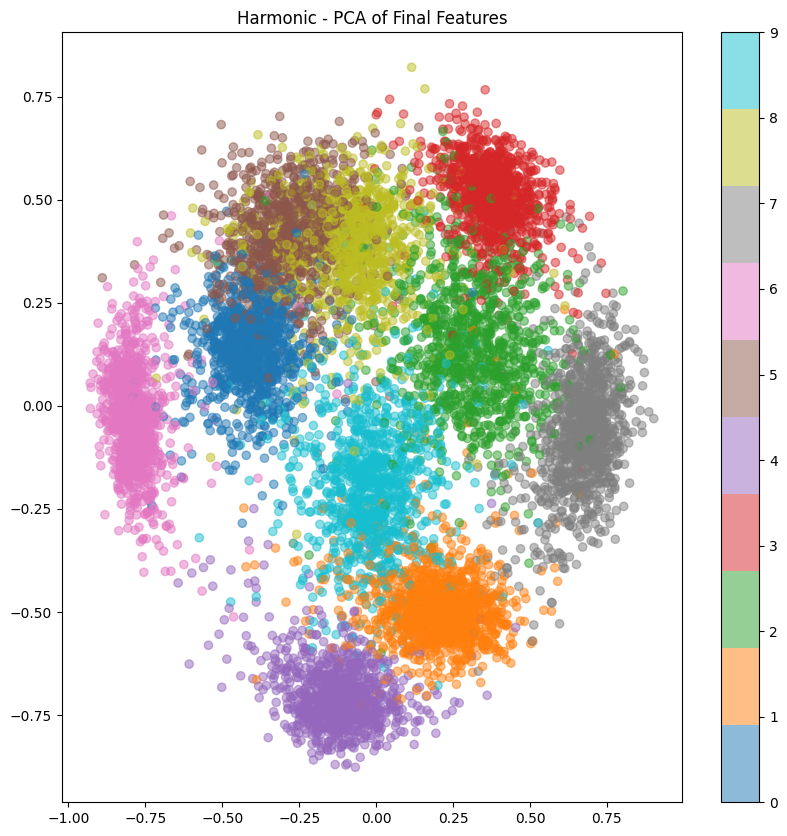

Total parameters: 20,464, Trainable parameters: 20,464


eval / error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval / loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
harmonic / distance_median,██▅▁▁▁▁▁▁▁▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
harmonic / effective_samples,███▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
harmonic / prob_median,███▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train / error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train / gradient_norm,▇▆▇▇▆▇▅▇▇▅▇▄▆▃▂▅▃▄▄▄▂█▃▃▃▄▁▄▄▂▂▃▄▁▃▃▃▄▁▃
train / loss,█▆▆▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval / error,0.0099
eval / loss,0.02922
harmonic / distance_median,3.47955


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import optuna
from tqdm import tqdm
import wandb


class DistLayer(torch.nn.Linear):
    def __init__(self, in_features, out_features, eps=1e-4):
        super(DistLayer, self).__init__(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x):
        diff = x[:, None, :] - self.weight[None, :, :]
        dist_sq = torch.sum(diff ** 2, dim=-1)
        return dist_sq


class SlimHarmonicNet(nn.Module):
    def __init__(self, eps=1e-8, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.gap = nn.AdaptiveAvgPool2d(4)
        self.fc1 = nn.Linear(16 * 16, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.classifier = DistLayer(32, 10, eps=eps)
        self.last_features = None  # Initialize last_features

    def forward(self, x):
        x = F.silu(self.bn1(self.conv1(x)))
        x = F.silu(self.bn2(self.conv2(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = F.silu(self.bn3(self.fc1(x)))
        x = self.dropout1(x)
        features = F.silu(self.bn4(self.fc2(x)))
        features = self.dropout2(features)
        self.last_features = features
        return self.classifier(features)


class ReferenceClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        self.last_features = None

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout1(x)
        self.last_features = x  # Store features before the final layer
        return self.fc2(x)


class HarmonicLoss(nn.Module):
    def __init__(self, harmonic_exp=-4.5):
        super().__init__()
        self.harmonic_exp = harmonic_exp
        self.current_stats = {
            'distance_median': 0.0,
            'prob_median': 0.0,
            'effective_samples': 0.0
        }

    def forward(self, distances, targets, update_stats=False):
        distances = distances.clamp(min=1e-8)
        dinv = distances ** self.harmonic_exp
        sum_dinv = torch.sum(dinv, dim=-1, keepdim=True).clamp(min=1e-8)
        probs = dinv / sum_dinv

        if update_stats:
            with torch.no_grad():
                self._update_stats(distances, probs)

        logits = -torch.log(probs.clamp(min=1e-10))
        loss = logits[range(targets.size(0)), targets].mean()
        return loss

    def _update_stats(self, distances, probs):
        self.current_stats['distance_median'] = torch.median(distances).item()
        self.current_stats['prob_median'] = torch.median(probs).item()
        self.current_stats['effective_samples'] = (probs > 0.01).float().sum(dim=1).mean().item()

def train_epoch(model, loader, criterion, optimizer, scheduler, device, scaler, is_harmonic):
    model.train()
    correct = 0
    total = 0

    for step, (x, y) in enumerate(tqdm(loader, desc="Training", leave=False)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device):
            outputs = model(x)
            loss = criterion(outputs, y, step % 100 == 0 and is_harmonic)

        scaler.scale(loss).backward()
        # Unscale gradients and clip
        # scaler.unscale_(optimizer)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if step % 20 == 0 and is_harmonic:
            grad_norm = None
            grads = [p.grad for p in model.parameters() if p.grad is not None]
            if grads:
                grad_norm = torch.norm(torch.stack([g.norm() for g in grads])).item()

            wandb.log({
                "train / gradient_norm": grad_norm,
                "train / loss": loss.item(),
                "harmonic / distance_median": criterion.current_stats['distance_median'],
                "harmonic / prob_median": criterion.current_stats['prob_median'],
                "harmonic / effective_samples": criterion.current_stats['effective_samples'],
            })

        if is_harmonic:
            dinv = outputs ** criterion.harmonic_exp
            probs = dinv / torch.sum(dinv, dim=-1, keepdim=True)
            pred = probs.argmax(dim=1)
        else:
            pred = outputs.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.size(0)

    epoch_accuracy = correct / total
    wandb.log({"train / error": 1-epoch_accuracy})
    print(f"Train loss: {loss.item():.4f}, Train error: {1-epoch_accuracy:.3%}")
    return epoch_accuracy


def evaluate(model, loader, criterion, device, is_harmonic):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            if is_harmonic:
                dinv = outputs ** criterion.harmonic_exp
                probs = dinv / torch.sum(dinv, dim=-1, keepdim=True)
                pred = probs.argmax(dim=1)
            else:
                pred = outputs.argmax(dim=1)

            correct += (pred == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    wandb.log({
        "eval / loss": avg_loss,
        "eval / error": 1-accuracy,
    })
    print(f"Eval loss: {avg_loss:.4f}, Eval error: {1-accuracy:.3%}")

def visualize_results(model, test_loader, device, model_name):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            _ = model(x)
            # L2-normalize features along the channel
            feat = model.last_features.cpu().numpy()
            norm = np.linalg.norm(feat, axis=1, keepdims=True) + 1e-8
            features.append(feat / norm)
            labels.append(y.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.title(f'{model_name} - PCA of Final Features')
    plt.colorbar(scatter)
    plt.show()

def count_parameters(model):
    total = trainable = 0
    for name, p in model.named_parameters():
        params = p.numel()
        total += params
        if p.requires_grad:
            trainable += params
    print(f"Total parameters: {total:,}, Trainable parameters: {trainable:,}")

def get_optimizer_and_scheduler(model, lr, weight_decay, total_steps, warmup_steps):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return max(
            0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps))
        )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return optimizer, scheduler

def run_experiment(model_type, epochs=20, batch_size=128, lr=5e-4, harmonic_exp=-5., eps=1e-4, weight_decay=0.002, dropout_rate=0.01, device='cuda'):
    # Data loading (same for both models)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

    # Model setup
    if model_type == 'harmonic':
        model = SlimHarmonicNet(eps=eps, dropout_rate=dropout_rate).to(device)
        criterion = HarmonicLoss(harmonic_exp=harmonic_exp)
        is_harmonic = True
    elif model_type == 'reference':
        model = ReferenceClassifier(dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        is_harmonic = False
    else:
        raise ValueError("Invalid model_type. Choose 'harmonic' or 'reference'.")


    total_steps = epochs * len(train_loader)
    warmup_steps = int(0.1 * total_steps)
    optimizer, scheduler = get_optimizer_and_scheduler(model, lr, weight_decay, total_steps, warmup_steps)

    if wandb.run is not None:
        wandb.finish()

    wandb.init(project="mnist-harmonic", entity="pink-marker")
    scaler = torch.amp.GradScaler(device)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler, is_harmonic)
        evaluate(model, test_loader, criterion, device, is_harmonic)

    # Visualize results
    visualize_results(model, test_loader, device, model_type.capitalize())
    count_parameters(model)
    wandb.finish()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
run_experiment('harmonic')


# model, metrics = run_experiment('reference')
# count_parameters(model)

# Run Optuna optimization
# study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
# study.optimize(objective, n_trials=50)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # Run experiment with best parameters:
# best_params = study.best_params
# best_model_type = best_params.pop('model_type')  # Extract and remove model_type
# model, metrics = run_experiment(best_model_type, device=device, **best_params)
# count_parameters(model)
